## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [47]:
# Import all the libraries needed.
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Step1: Calibrate the camera

In [48]:
# Calibrate the camera, calculate the mtx and dist of camera, and store them in the pickle file.
def CalibrateCamera(imgnames, pointnum=(9,6)):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((pointnum[0]*pointnum[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:pointnum[0], 0:pointnum[1]].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    for idx, imgname in enumerate(imgnames):
        # Read image
        img = cv2.imread(imgname)
        
        #image size
        img_size = (img.shape[1], img.shape[0])
        
        # Grayscale the image.
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, pointnum, None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Save the image with drawed corners
            cv2.drawChessboardCorners(img, pointnum, corners, ret)
            write_name = 'output_images/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    # Save the camera calibration result for later use.
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "output_images/wide_dist_pickle.p", "wb" ) )
    
    return

In [49]:
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

CalibrateCamera(images)

### Step2: Undistort the image

In [50]:
# Undistort the image with saved calibration pickle data.
def undistort(image, mtx, dist):
        
    # undistort the images by calling the cv2.undistort api, and save the undistorted images.
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    
    return dst

### Step3: Detect edges with thresholds

In [51]:
def findedges(img, white_thresh=(200, 255), yellow_s_thresh=(180, 255), yellow_h_thresh=(10, 40)):
    # The image cliped with moviepy from the video is RGB!!! 
    
    # Convert to HLS color space
    hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsl[:,:,0]
    l_channel = hsl[:,:,1]
    s_channel = hsl[:,:,2]
    
    # Filter White color
    white_binary = np.zeros_like(l_channel)
    white_binary[(l_channel > white_thresh[0]) & (l_channel <= white_thresh[1])] = 1
    
    # Filter Yellow color
    yellow_s_binary = np.zeros_like(s_channel)
    yellow_s_binary[(s_channel > yellow_s_thresh[0]) & (s_channel <= yellow_s_thresh[1])] = 1
    
    yellow_h_binary = np.zeros_like(h_channel)
    yellow_h_binary[(h_channel > yellow_h_thresh[0]) & (h_channel <= yellow_h_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(white_binary)
    combined_binary[(white_binary == 1) | 
                    ((yellow_s_binary == 1) & (yellow_h_binary == 1))]  = 1
    
    return combined_binary

### Step4 Perspective transform to bird-eye view

In [52]:
# Get the perspective transform M, and Minv
def warp(img_size, offset=200):
    # define 4 source points src = np.float32([[,],[,],[,],[,]])
    src = np.float32([[572,  465], 
                      [712,  465], 
                      [1100, 720], 
                      [200,  720]])
    
    # define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    # the dst has a offset of the left and right side to capture the lines in case of curvature. 
    # no offset is needed for the up and down side.    
    dst = np.float32([[offset, 0], 
                      [img_size[0]-offset, 0], 
                      [img_size[0]-offset, img_size[1]], 
                      [offset, img_size[1]]])
    
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return M, Minv

### Step5: Finding lane lines

In [53]:
def findlines(binary_warped, nwindows=9, margin=100, minpix=50):
    # Take a histogram of all the image, half of the image may not include the edges detected.
    histogram = np.sum(binary_warped[:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,100,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,100,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [100, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 100]
    
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    return left_fit, right_fit

### Step6: Draw the lane line on the origin image

In [54]:
def visualizelines(undist, img_size, left_fit, right_fit, Minv):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_size[1]-1, img_size[1])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    color_warp = np.zeros_like(undist).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size, flags=cv2.INTER_LINEAR) 

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

### Step7: Calculate the curvature

In [55]:
def calcurvature(left_fit, right_fit, img_size, ym_per_pix = 30/720, xm_per_pix = 3.7/700):
    # Generate x and y values in image space
    ploty = np.linspace(0, img_size[1]-1, img_size[1])
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Select the y max as the point of calculation
    y_eval = np.max(ploty)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    #print(np.int(left_curverad), 'm', np.int(right_curverad), 'm')
    return np.int(left_curverad), np.int(right_curverad)

### Pipeline for image

In [56]:
def process_image(image, mtx, dist, M, Minv):
    
    # Get the image size
    img_size = (image.shape[1], image.shape[0])
    
    # Undistort the image
    undist = undistort(image, mtx, dist)
    
    # Find the edges
    binary_edges = findedges(undist)
    
    # Perspective transform
    binary_warped = cv2.warpPerspective(binary_edges, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Calculate the coefficience of poly fit of lane pixels found.
    left_fit, right_fit = findlines(binary_warped)
    
    # Draw the lane on the original image
    result = visualizelines(undist, img_size, left_fit, right_fit, Minv)
    
    # Calculate the curvature
    left_curv, right_curv = calcurvature(left_fit, right_fit, img_size)
    
    cv2.putText(result, 
                "Lane curvature: "+str(left_curv)+' '+str(right_curv),
                (300,60), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                1.5,
                (255,255,255),
                2)
    
    return undist, binary_edges, binary_warped, result, left_curv, right_curv

### Generate the result of each step

In [57]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open("output_images/wide_dist_pickle.p", "rb" ))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

image = cv2.imread('test_images/project_video0204.jpg')

# The pipeline requires the color space in RGB! 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

img_size = (image.shape[1], image.shape[0])

M, Minv = warp(img_size)

undist, binary_edges, binary_warped, result, left_curv, right_curv = process_image(image, mtx, dist, M, Minv)

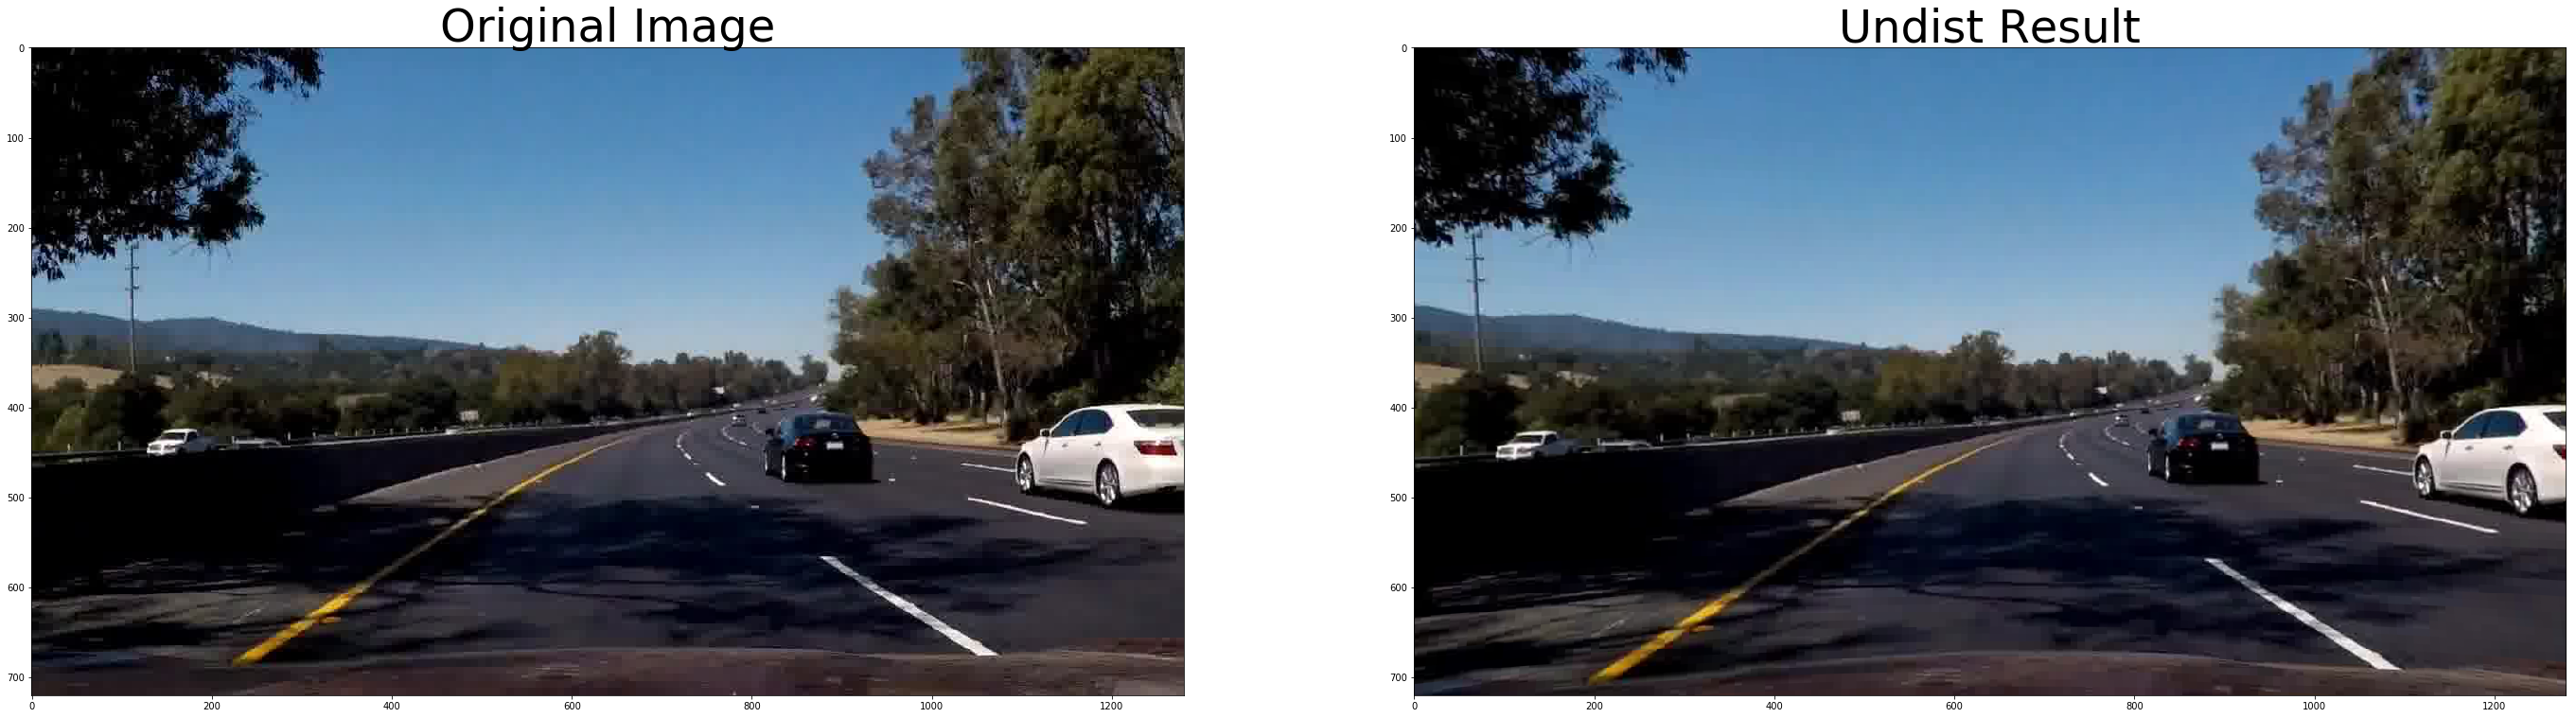

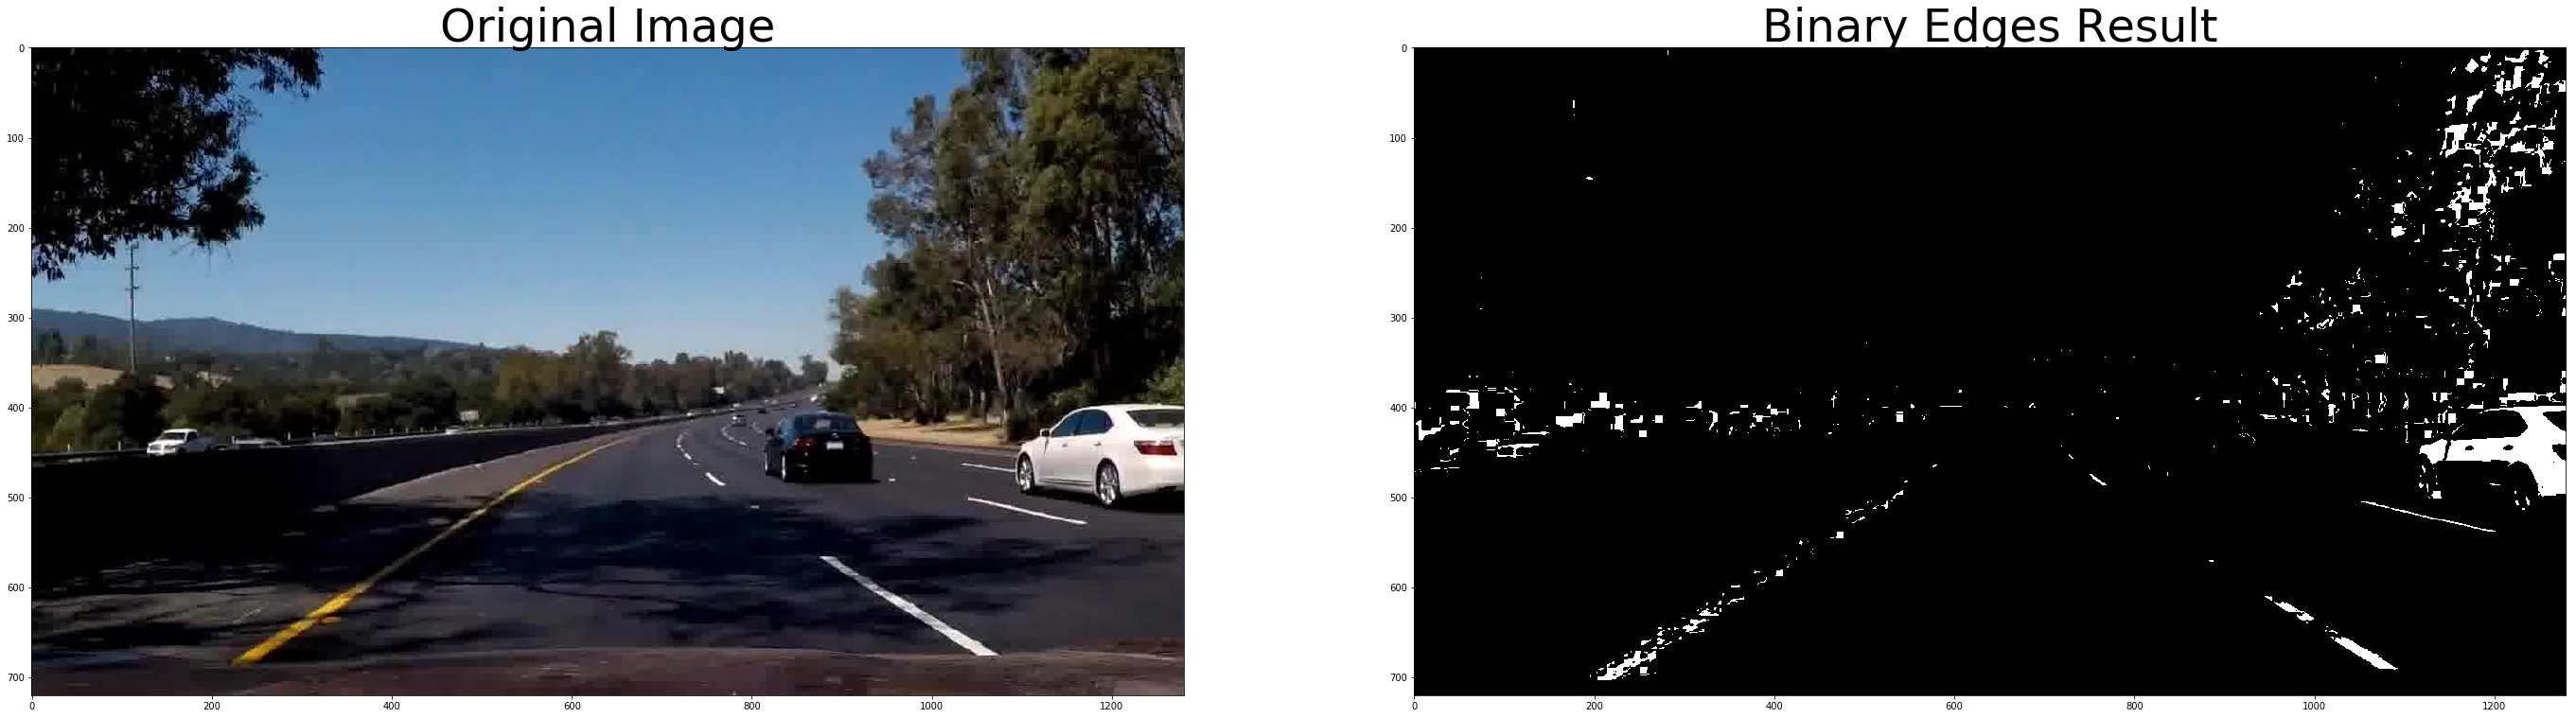

In [58]:
# Plot the result
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(48, 18))
f, ((ax3, ax4)) = plt.subplots(1, 2, figsize=(48, 18))

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=48)

ax2.imshow(undist)
ax2.set_title('Undist Result', fontsize=48)

ax3.imshow(image)
ax3.set_title('Original Image', fontsize=48)

ax4.imshow(binary_edges, cmap='gray')
ax4.set_title('Binary Edges Result', fontsize=48)

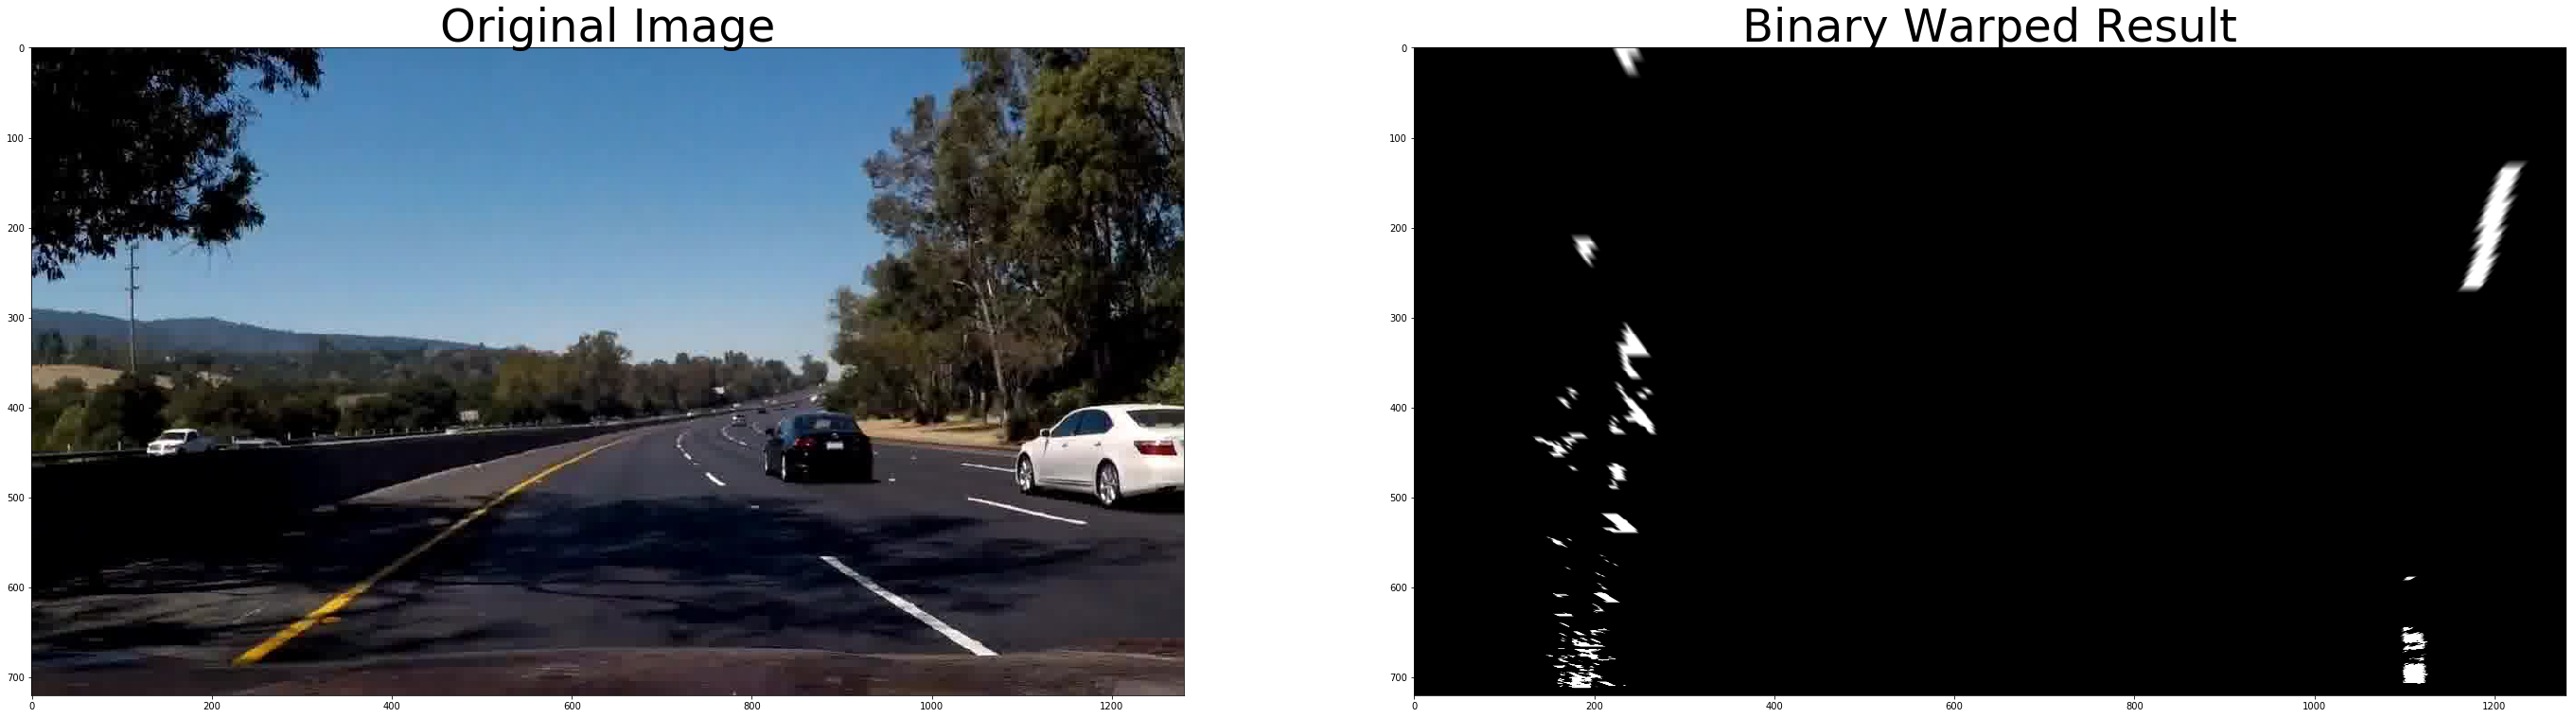

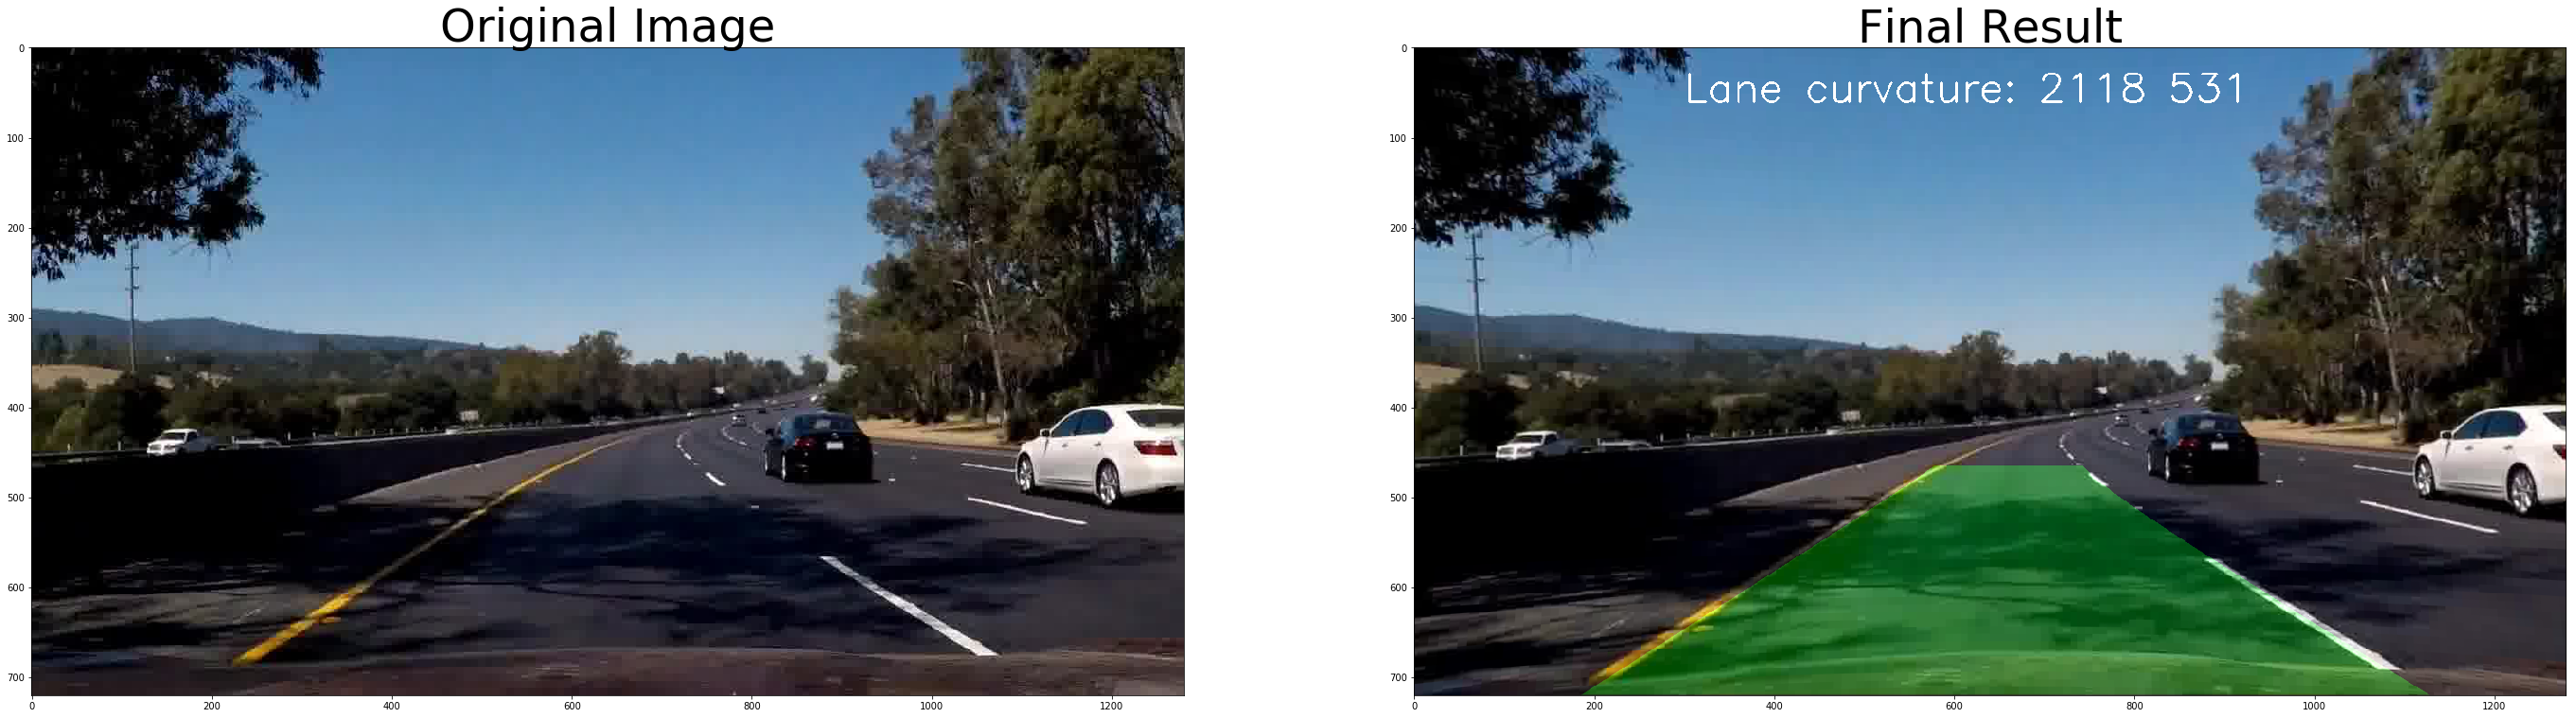

In [59]:
f, ((ax5, ax6)) = plt.subplots(1, 2, figsize=(48, 18))
f, ((ax7, ax8)) = plt.subplots(1, 2, figsize=(48, 18))

ax5.imshow(image)
ax5.set_title('Original Image', fontsize=48)

ax6.imshow(binary_warped, cmap='gray')
ax6.set_title('Binary Warped Result', fontsize=48)

ax7.imshow(image)
ax7.set_title('Original Image', fontsize=48)

ax8.imshow(result)
ax8.set_title('Final Result', fontsize=48)

## Test On the video

In [60]:
def process_video(image):
    
    # Get the image size
    img_size = (image.shape[1], image.shape[0])
    
    # Undistort the image
    undist = undistort(image, mtx, dist)
    
    # Find the edges
    binary_edges = findedges(undist)
    
    # Perspective transform
    binary_warped = cv2.warpPerspective(binary_edges, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Calculate the coefficience of poly fit of lane pixels found.
    left_fit, right_fit = findlines(binary_warped)
    
    # Draw the lane on the original image
    result = visualizelines(undist, img_size, left_fit, right_fit, Minv)
    
    # Calculate the curvature
    left_curv, right_curv = calcurvature(left_fit, right_fit, img_size)
    
    cv2.putText(result, 
            "Lane curvature: "+str(left_curv)+' '+str(right_curv),
            (300,60), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            1.5,
            (255,255,255),
            2)
    
    return result

In [61]:
# Prepare the parameters for the process_video
dist_pickle = pickle.load(open( "output_images/wide_dist_pickle.p", "rb" ))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
image = cv2.imread('test_images/test3.jpg')
img_size = (image.shape[1], image.shape[0])
M, Minv = warp(img_size)

# Generate the video
project_video_output = 'output_videos/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [02:46<00:00,  7.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

Wall time: 2min 48s


In [62]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))